In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
mnist = np.genfromtxt('MNIST_Shortened.csv', delimiter=',',
skip_header=1)

In [5]:
# Define X and y
X = mnist[:,0:784]
y = mnist[:,-1]

C:\Users\madhu\AppData\Local\Temp\ipykernel_18160\3315934217.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="viridis")


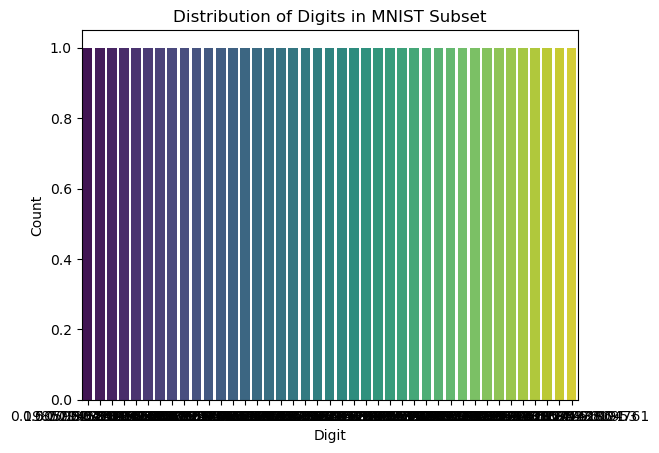

In [41]:
# Distribution of digits
sns.countplot(x=y, palette="viridis")
plt.title("Distribution of Digits in MNIST Subset")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


In [6]:
# Check dimensions of X
X.shape

(6000, 784)

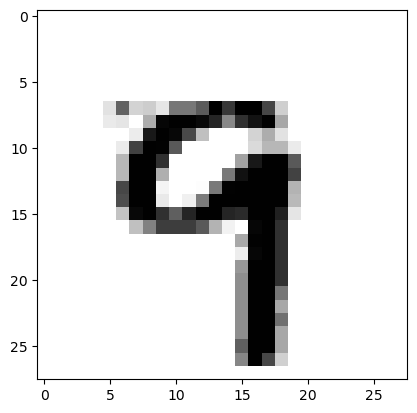

In [7]:
plt.imshow(X[0].reshape(28,28),cmap='gray_r')
plt.show()

In [55]:
# Reload dataset correctly
mnist = np.genfromtxt('MNIST_Shortened.csv', delimiter=',', skip_header=1)

y = mnist[:, 0]      # labels are in first column
X = mnist[:, 1:785]  # pixels are in next 784 columns

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6000, 784)
y shape: (6000,)


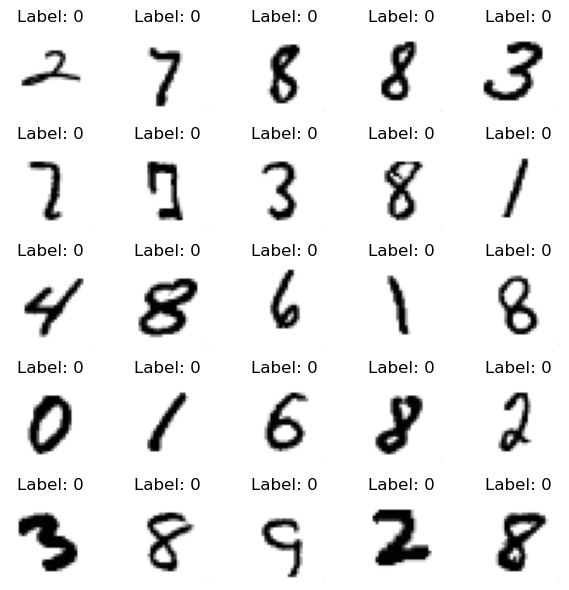

In [57]:
fig, axes = plt.subplots(5, 5, figsize=(6,6))
for ax in axes.flat:
    idx = np.random.randint(0, X.shape[0])
    ax.imshow(X[idx].reshape(28,28), cmap="gray_r")
    ax.set_title(f"Label: {int(y[idx])}")
    ax.axis("off")
plt.tight_layout()
plt.show()


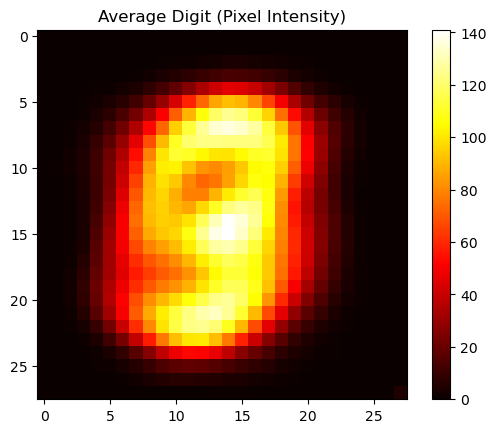

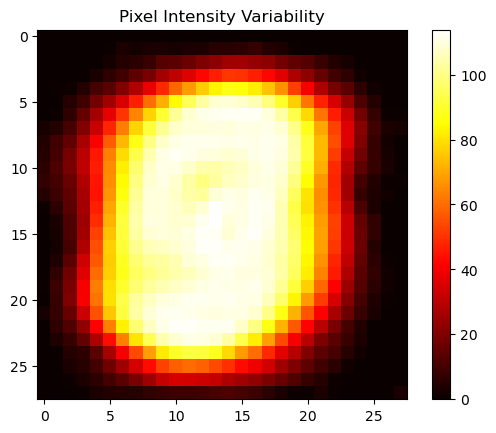

In [69]:
# Mean digit
plt.imshow(X.mean(axis=0).reshape(28,28), cmap="hot")
plt.title("Average Digit (Pixel Intensity)")
plt.colorbar()
plt.show()

# Standard deviation digit
plt.imshow(X.std(axis=0).reshape(28,28), cmap="hot")
plt.title("Pixel Intensity Variability")
plt.colorbar()
plt.show()


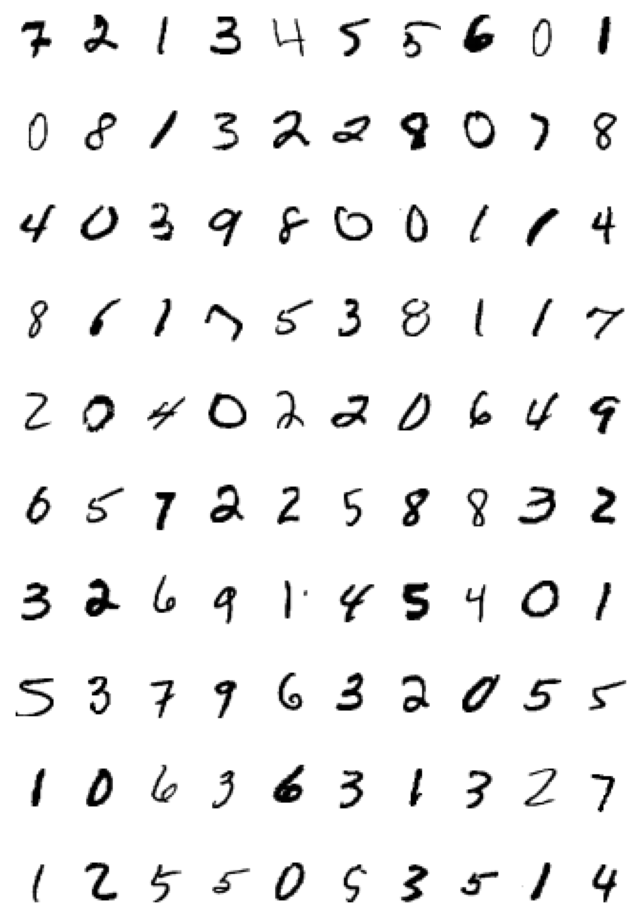

In [8]:
plt.figure(figsize=(8, 12))

for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(X[np.random.randint(0,6000)].reshape(28,28),cmap='gray_r')
    plt.axis('off')
plt.show()

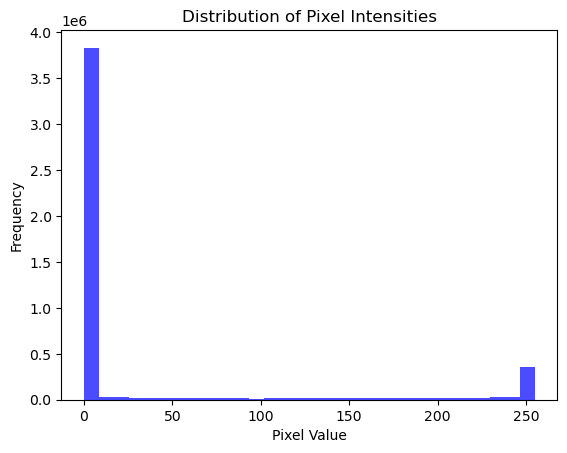

In [71]:
plt.hist(X.ravel(), bins=30, color="blue", alpha=0.7)
plt.title("Distribution of Pixel Intensities")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()


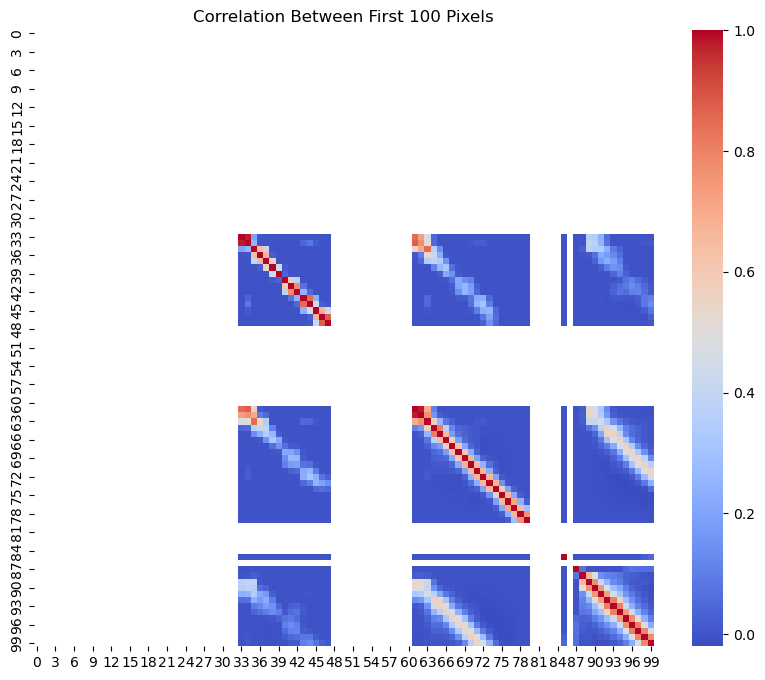

In [73]:
# Correlation heatmap of first 100 pixels
corr_matrix = pd.DataFrame(X[:, :100]).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.title("Correlation Between First 100 Pixels")
plt.show()


In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.3, random_state=0, stratify=y)

In [10]:
from sklearn.feature_selection import VarianceThreshold
variance_selector = VarianceThreshold(threshold=0)
X_train_fs = variance_selector.fit_transform(X_train)
X_test_fs = variance_selector.transform(X_test)
print(f"{X_train.shape[1]-X_train_fs.shape[1]} features have been removed, {X_train_fs.shape[1]} features remain")

118 features have been removed, 666 features remain


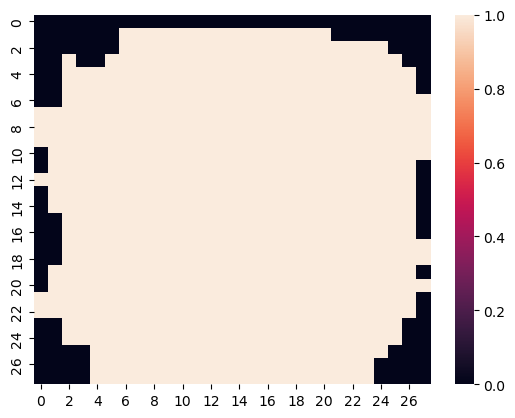

In [11]:
# We can use the get_support function to see which features have been dropped
selected_features = variance_selector.get_support()
selected_features = selected_features.reshape(28,28)
# Visualise which pixels have been dropped
sns.heatmap(selected_features,cmap='rocket')
plt.show()

In [12]:
# Use the SelectKBest selector from sklearn to select the k features with the best scores on a selected test statistic
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=200)
X_train_fs = selector.fit_transform(X_train_fs, y_train)
X_test_fs = selector.transform(X_test_fs)

In [13]:
new_features_indices = \
variance_selector.get_support(indices=True)[selector.get_support()]
new_features_boolean = np.isin(np.arange(784), new_features_indices)

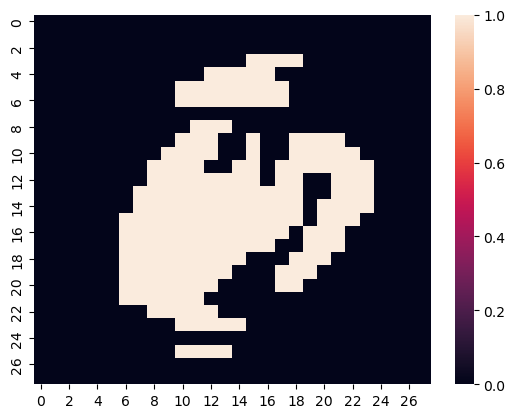

In [14]:
sns.heatmap(new_features_boolean.reshape(28,28),cmap='rocket')
plt.show()

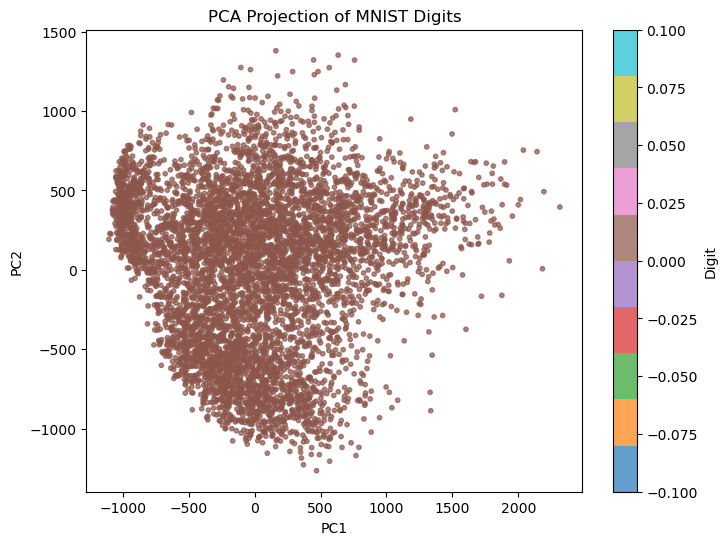

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=10, alpha=0.7)
plt.colorbar(label="Digit")
plt.title("PCA Projection of MNIST Digits")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import RFECV

In [16]:
scaler = StandardScaler()
X_train_fs = scaler.fit_transform(X_train_fs)
X_test_fs = scaler.transform(X_test_fs)

In [17]:
rf = RandomForestClassifier(random_state=0) # Use RandomForestClassifier as the base model
rfecv = RFECV(rf, cv=3, step=5)
X_train_fs = rfecv.fit_transform(X_train_fs, y_train)
X_test_fs = rfecv.transform(X_test_fs)
print(f"Number of remaining features: {X_train_fs.shape[1]}")

Number of remaining features: 195


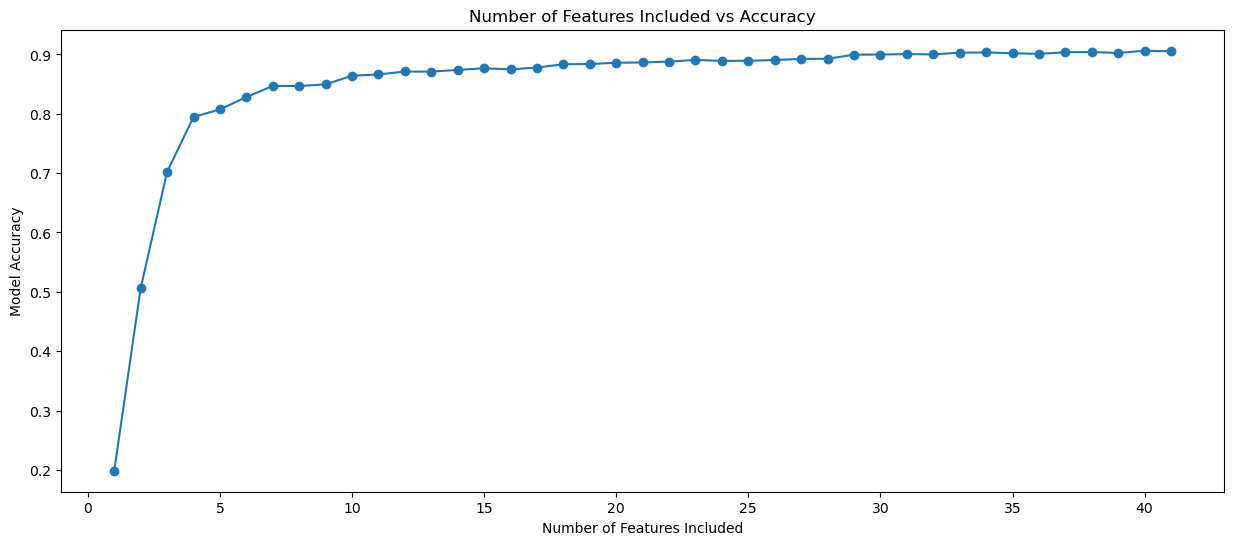

In [18]:
plt.figure(figsize=(15, 6))
plt.title('Number of Features Included vs Accuracy')
plt.xlabel('Number of Features Included')
plt.ylabel('Model Accuracy')

# X = range of tested feature counts
x = range(1, len(rfecv.cv_results_['mean_test_score']) + 1)
y = rfecv.cv_results_['mean_test_score']

plt.plot(x, y, marker='o')
plt.show()


In [37]:
rf_selectedfeatures = RandomForestClassifier()
rf_selectedfeatures.fit(X_train_fs, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy Score: 91.39%


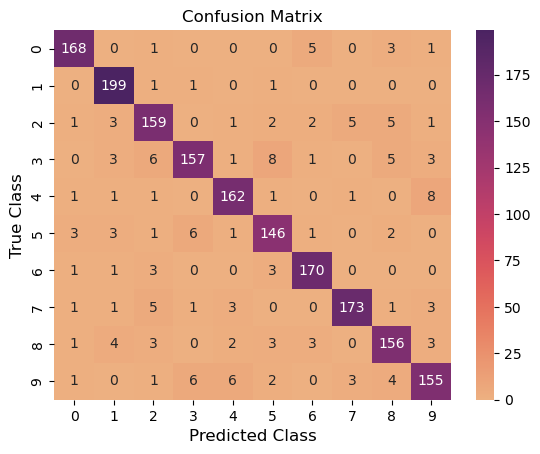

In [39]:
y_pred = rf_selectedfeatures.predict(X_test_fs)
print(f"Accuracy Score: {accuracy_score(y_test,y_pred)*100:.2f}%")
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm, cmap='flare',annot=True, fmt='d')
plt.xlabel("Predicted Class",fontsize=12)
plt.ylabel("True Class",fontsize=12)
plt.title("Confusion Matrix",fontsize=12)
plt.show()